In [1]:
import pandas as pd
import numpy as np
import pickle
import keras
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt # 그래프 그리는 라이브러리

2025-11-19 11:22:16.147303: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 11:22:16.148581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 11:22:16.191938: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 11:22:16.193452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 11:22:17.014048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:3

In [2]:
PAST_STEP = 36 # 관측 데이터 사용량 (10분단위, 6시간, 36 STEP)
FORECAST_STEP = 72 # 예보 데이터 사용량 ( 10분단위, 12시간, 72 STEP )

# 유량 예측 모델일 시 이 변수 사용
# DG_OUTPUT_COL = ['서울시(대곡교)_FW']
# GN_OUTPUT_COL = ['성남시(궁내교)_FW']
# DG_WL_COL = ['서울시(대곡교)_WL']
# GN_WL_COL = ['성남시(궁내교)_WL']
# INPUT1_COL = [
#                 '성남시(한국학중앙연구원)','성남시(대장동)', '성남시(구미초교)',
#                 '서울시(대곡교)',  '성남시(성남북초교)', '광주시(남한산초교)',
#                 '궁내교_Ti', '대곡교_Ti', '성남시(궁내교)_FW', '서울시(대곡교)_FW' ]

# # 수위 예측 모델일 시 이 변수 사용
DG_OUTPUT_COL = ['서울시(대곡교)_WL']
GN_OUTPUT_COL = ['성남시(궁내교)_WL']
INPUT1_COL = [
                '성남시(한국학중앙연구원)','성남시(대장동)', '성남시(구미초교)',
                '서울시(대곡교)',  '성남시(성남북초교)', '광주시(남한산초교)',
                '궁내교_Ti', '대곡교_Ti', '성남시(궁내교)_WL', '서울시(대곡교)_WL' ]

INPUT2_COL = [
                '성남시(한국학중앙연구원)','성남시(대장동)', '성남시(구미초교)',
                '서울시(대곡교)',  '성남시(성남북초교)', '광주시(남한산초교)',
                '궁내교_Ti', '대곡교_Ti', 
            ]

# target_key = 'gn' # 궁내교
target_key = 'dg' # 대곡교
TARGET_COL = DG_OUTPUT_COL if target_key == 'dg' else GN_OUTPUT_COL

testdata_dir = './testdata'


testdata_220630 = f'{testdata_dir}/36step/220630_1600.xlsx'
testdata_220808 = f'{testdata_dir}/36step/220808_2200.xlsx'
testdata_250716 = f'{testdata_dir}/36step/250716_1700.xlsx'
testdata_250814 = f'{testdata_dir}/36step/250814_0500.xlsx'

testdata_220630 = pd.read_excel(testdata_220630) # 220630 테스트 데이터 Dataframe
testdata_220808 = pd.read_excel(testdata_220808) # 220808 테스트 데이터 Dataframe
testdata_250716 = pd.read_excel(testdata_250716) # 250716 테스트 데이터 Dataframe
testdata_250814 = pd.read_excel(testdata_250814) # 250814 테스트 데이터 Dataframe

dataset_list = [testdata_220630, testdata_220808, testdata_250716, testdata_250814]

#worker = "swkim"
worker = "jmlee"

# # 모델 저장 경로 
# dir_model = f'./model_stage/{worker}/model_sungnam_{target_key}'

# # 스케일러 저장 경로
# scalerfile = f'./model_stage/{worker}/scaler_{target_key}.pkl'

# # 모델 저장 경로 
# dir_model = f'./model_stage/model_{target_key}36_wl'

# # 스케일러 저장 경로
# scalerfile = f'./model_stage/scaler_{target_key}36_wl.pkl'

# 모델 저장 경로 
dir_model = f'./model_stage/model_{target_key}_ver2'

# 스케일러 저장 경로
scalerfile = f'./model_stage/scaler_{target_key}_ver2.pkl'

#스케일러 로드
with open(scalerfile, 'rb') as file:
    scaler_x = pickle.load(file)
    scaler_f = pickle.load(file)
    scaler_y = pickle.load(file)


In [4]:
model = keras.models.load_model(dir_model) # 모델 로드

In [5]:
def make_input_data(df): 
    # 입력데이터 생성
    df_input1 = df.iloc[:PAST_STEP]
    df_input1 = df_input1[INPUT1_COL]
    input1 = np.array(df_input1)
    
    df_input2 = df.iloc[PAST_STEP:]
    df_output = df_input2[TARGET_COL]
    df_input2 = df_input2[INPUT2_COL]
    
    input2 = np.array(df_input2)
    output = np.array(df_output).flatten()
    
    
    input1 =  scaler_x.transform(input1) # 입력자료 1(관측) 데이터 스케일링
    input2 =  scaler_f.transform(input2) # 입력자료 2(예보) 데이터 스케일링

    input1 = input1.reshape(1, input1.shape[-2], input1.shape[-1])
    input2 = input2.reshape(1, input2.shape[-2], input2.shape[-1])
    
    return input1, input2, output
    
def HQCurve(waterlevel):
    # 수위로 유량을 구하는 곡선식 (23.11 ~ 부터 적용 )
    if waterlevel >= 0.54 and waterlevel <= 1.31 :
        return 40.769 * (waterlevel - 0.540) ** 1.728
    elif waterlevel > 1.31 and waterlevel <= 2.42 :
        return 13.779 * ( waterlevel - 0.040 ) ** 2.649
    else :
        return 22.778 * ( h - 0.400 ) ** 2.552
        
def QHCurve(flow):
    # 유량으로 수위를 구하는 곡선식 (23.11 ~ 부터 적용 )
    if flow >= HQCurve(0.54) and flow <= HQCurve(1.31) :
        return  0.540 + ( flow / 40.769 ) ** (1/1.728)
    elif flow > HQCurve(1.31) and flow <= HQCurve(2.42) :
        return 0.040 + ( flow / 13.779 ) ** (1/2.649)
    else :
        return 0.400 + ( flow / 22.778 ) ** (1/2.552)

def drawCorrectionGraph(y_real, y_pred, pred_type):
    # 예측 결과 비교 그래프
    # y_real : 관측, y_pred : 예측

    plt.figure(figsize=(15, 8))
    
    plt.plot(y_real, 'blue')
    plt.plot(y_pred, 'orange')
    plt.legend([f'obs', f'pred'], loc='upper left')
    plt.title(f'Tancheon {pred_type} Prediction Result ')
    plt.xlabel('step')
    plt.ylabel(f'{pred_type}(m)')
    
    plt.tight_layout()
    plt.show()

In [6]:
input1, input2, output = make_input_data(testdata_250814) # 입 / 출력 데이터 testdata_220630 , testdata_220808 , testdata_250716 , testdata_250814

In [7]:
input1.shape # 입력데이터1 (관측) : 1, 36, 10의 3차원 배열

(1, 36, 10)

In [8]:
y_pred = model.predict([input1, input2]) # 모델 예측 수행
y_pred = scaler_y.inverse_transform(y_pred.reshape(1,-1)) # 예측 결과 역스케일링 (원본 스케일로 변화) => 1, 72, 1 의 3차원 배열
y_pred = y_pred[0] # 1, 72, 1 -> 72, 의 1차원 배열이 되도록 꺼냄

1/1 [==============================] - 1s 1s/step


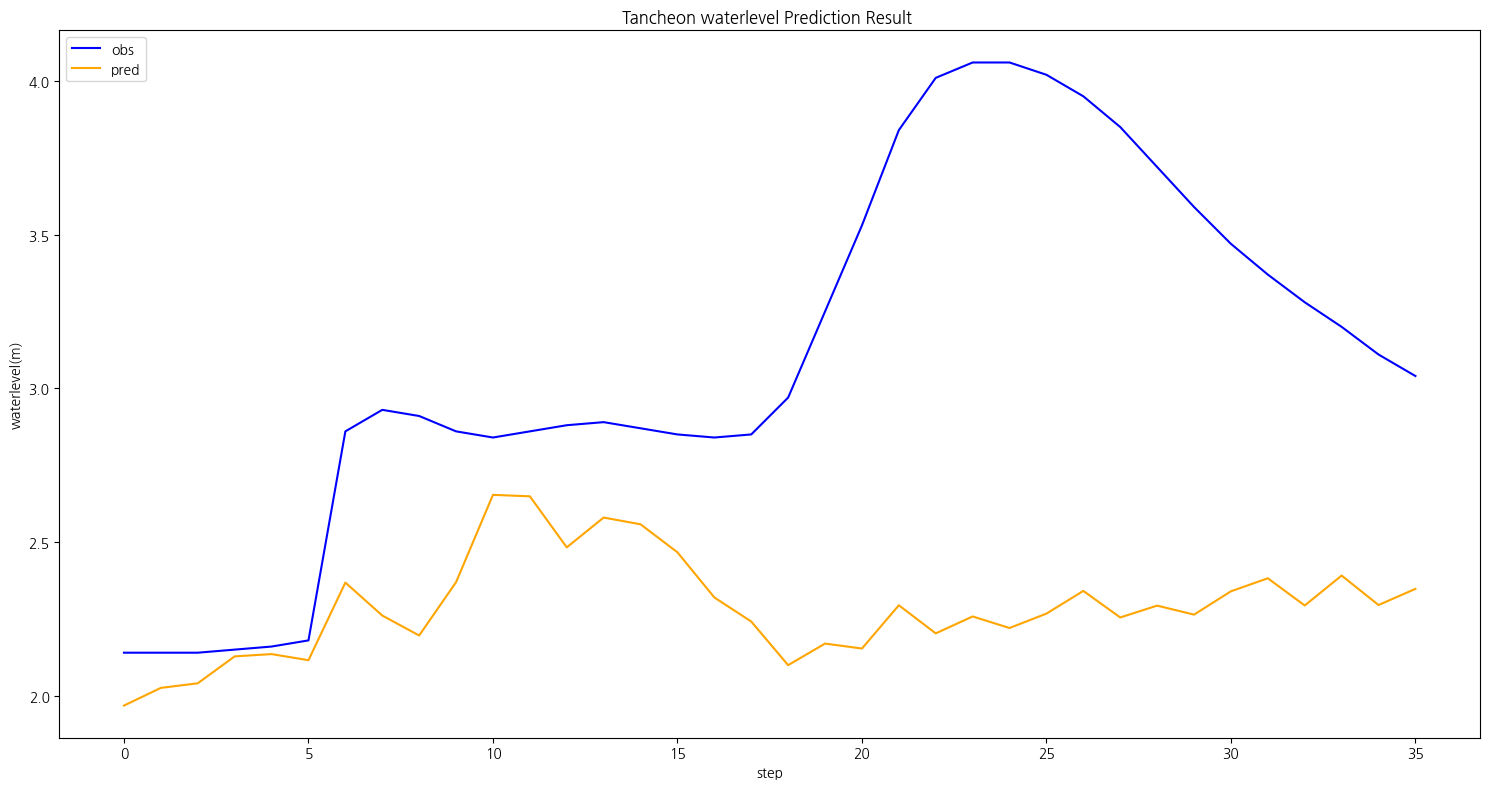

In [9]:
drawCorrectionGraph(output, y_pred, 'waterlevel')

In [10]:
# 메트릭 계산
r2 = r2_score(output, y_pred)
mse = mean_squared_error(output, y_pred)
mae = mean_absolute_error(output, y_pred)
rmse = np.sqrt(mse)

In [11]:
# 메트릭 계산 결과 출력
print(f'''
r2 : {r2}
mse : {mse}
mae : {mae}
rmse : {rmse}
''')


r2 : -1.8690730778102687
mse : 0.9958523873797022
mae : 0.8124044648806253
rmse : 0.9979240388825705

